# **Movie Recommendation System**

**Report**: https://docs.google.com/document/d/1rRhMzcAsseQS-6gd9Dyr0NW5RnBc8evll0n5KM6rwxo/edit?usp=sharing

**Context**: This project give suggestions to users based on the features they love the most. It suggests movies that match the similarities with the highest degree of performance.

**Objective:** Recommending movies using:

1. user-item rating data to identify patterns in preferences.

2. Implement item-based collaborative filtering to find similar movies.

3. Apply cosine similarity to measure how closely movies are rated.

4. Deliver a Jupyter Notebook that:

i. Produces movie recommendations.

ii. Includes charts (heatmaps, bar plots) to explain similarity and ranking.

**Dataset**: Anime Recommendations Database

**Source**: https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database

**Format**: CSV

**Key Concepts:** Collaborative filtering, similarity scores, cosine similarity.

**Tools:** Pandas, Surprise (optional), Scikit-learn.

### Import Libraries

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

### Load Your Data

In [10]:
# Movie metadata
movies_system = pd.read_csv('anime.csv')  

# Ratings data
ratings_df = pd.read_csv('rating.csv')        

### Data Exploration Analysis

In [11]:
# Exploring anime data

movies_system.info()
movies_system.describe()
movies_system.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [12]:
# Exploring rating data

ratings_df.info()
ratings_df.describe()
ratings_df.head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB


<bound method NDFrame.head of          user_id  anime_id  rating
0              1        20      -1
1              1        24      -1
2              1        79      -1
3              1       226      -1
4              1       241      -1
...          ...       ...     ...
7813732    73515     16512       7
7813733    73515     17187       9
7813734    73515     22145      10
7813735    73516       790       9
7813736    73516      8074       9

[7813737 rows x 3 columns]>

<Axes: >

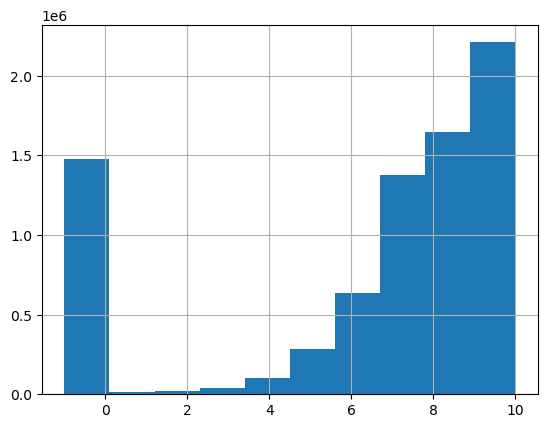

In [13]:
# Checking the distribution of the anime ratings

ratings_df['rating'].hist(bins=10)

In [14]:
# Count how many rows have a rating of -1

num_unrated = (ratings_df['rating'] == -1).sum()

print(f"Number of rows with rating -1 (unrated but watched): {num_unrated}")

Number of rows with rating -1 (unrated but watched): 1476496


In [15]:
# Removing rating == -1 because it signifies that the user watched it but didn't assign a rating

ratings_df = ratings_df[ratings_df['rating'] != -1]

In [16]:
# To see how many users and movies are in the dataset

print("Number of unique users:", ratings_df['user_id'].nunique())
print("Number of unique movies:", ratings_df['anime_id'].nunique())

Number of unique users: 69600
Number of unique movies: 9927


In [17]:
# Checking for large unique counts, to know if the dataset is too large to fit into memory

ratings_df.shape
ratings_df[['user_id', 'anime_id']].nunique()

user_id     69600
anime_id     9927
dtype: int64

In [18]:
# The dataset is very large, so i will Keep only active users and popular anime

active_users = ratings_df['user_id'].value_counts()[ratings_df['user_id'].value_counts() > 30].index
popular_anime = ratings_df['anime_id'].value_counts()[ratings_df['anime_id'].value_counts() > 50].index

filtered_df = ratings_df[
    ratings_df['user_id'].isin(active_users) &
    ratings_df['anime_id'].isin(popular_anime)
]

In [19]:
# sorting the DataFrame by the rating column in descending order, so higher-rated entries come first 
# and removing duplicate rows based on the combination of user_id and anime_id

filtered_df = filtered_df.sort_values('rating', ascending=False).drop_duplicates(['user_id', 'anime_id'])

### Creating User-Movie Ratings Matrix

In [20]:
# Transforming the filtered_df DataFrame into a user-item matrix

user_anime_matrix = filtered_df.pivot(index='user_id', columns='anime_id', values='rating').fillna(0)

In [21]:
# Saving anime IDs (columns) before conversion

anime_ids = user_anime_matrix.columns  

In [22]:
# converting the dense user-anime rating matrix into a sparse matrix, for memory efficiency and speed

from scipy.sparse import csr_matrix

sparse_matrix = csr_matrix(user_anime_matrix.values)

### Compute Item-Item Similarity (Cosine Similarity)

In [23]:
# item-item similarity to find similar anime based on user ratings
item_similarity = cosine_similarity(sparse_matrix.T)  


# Using saved anime_ids to label similarity DataFrame
item_similarity_df = pd.DataFrame(item_similarity, index=anime_ids, columns=anime_ids)

In [24]:
# Saving in a file to avoid recomputing the similarity matrix

import pickle
with open('item_similarity.pkl', 'wb') as f:
    pickle.dump(item_similarity, f)

### Creating a Recommendation Function

In [25]:
# Creating a function that returns the most similar anime (excluding the selected one), 
# including their name, rating, and similarity score.

def get_similar_anime(anime_id, similarity_df, movies_system, top_n=10):
    similar_scores = similarity_df[anime_id].sort_values(ascending=False)[1:top_n+1]
    similar_anime_ids = similar_scores.index

    # Fetching matching rows from metadata
    filtered = movies_system[movies_system['anime_id'].isin(similar_anime_ids)][['anime_id', 'name', 'rating']]

    # Merging similarity scores into result
    filtered = filtered.merge(similar_scores.rename("SimilarityScore"), left_on='anime_id', right_index=True)

    return filtered


### Visual Explanation of Recommendations

#### 1. Heatmap to show how similar movies are

In [26]:
# Creating a list of the top 10 highest-rated anime (from those with valid similarity data) for recommendation or analysis.

# 1. Make sure you have anime_df and item_similarity_df defined already
# 2. Filter anime_df to include only anime present in the similarity matrix
valid_anime_df = movies_system[movies_system['anime_id'].isin(item_similarity_df.index)]

# 3. Get top-rated anime among those valid ones
top_rated_valid = valid_anime_df.sort_values(by='rating', ascending=False).head(10)

# 4. Extract anime_id values
top_ids = top_rated_valid['anime_id'].values

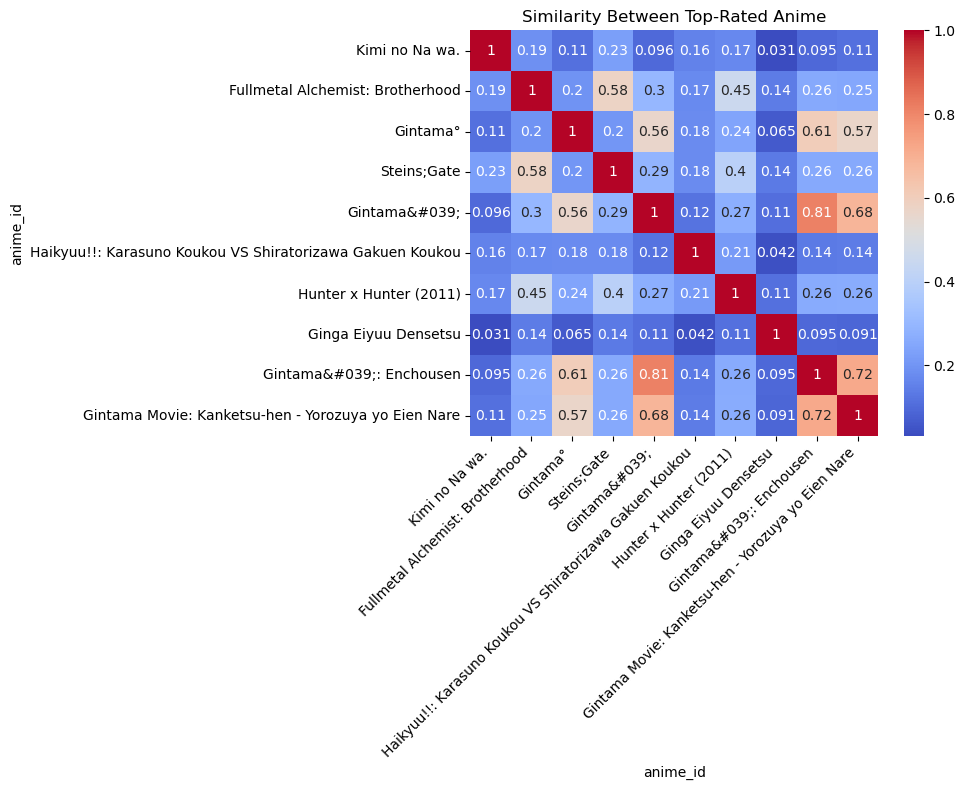

In [27]:
# Comparing the top-rated anime to each other

subset = item_similarity_df.loc[top_ids, top_ids]

plt.figure(figsize=(10, 8))
sns.heatmap(
    subset,
    annot=True,
    cmap='coolwarm',
    xticklabels=top_rated_valid['name'],
    yticklabels=top_rated_valid['name']
)
plt.title("Similarity Between Top-Rated Anime")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### 2. Bar plot to visualizes the top 5 anime that are most similar to the highest rated Anime

In [31]:
print(top_rated_valid['name'].tolist())

['Kimi no Na wa.', 'Fullmetal Alchemist: Brotherhood', 'Gintama°', 'Steins;Gate', 'Gintama&#039;', 'Haikyuu!!: Karasuno Koukou VS Shiratorizawa Gakuen Koukou', 'Hunter x Hunter (2011)', 'Ginga Eiyuu Densetsu', 'Gintama&#039;: Enchousen', 'Gintama Movie: Kanketsu-hen - Yorozuya yo Eien Nare']


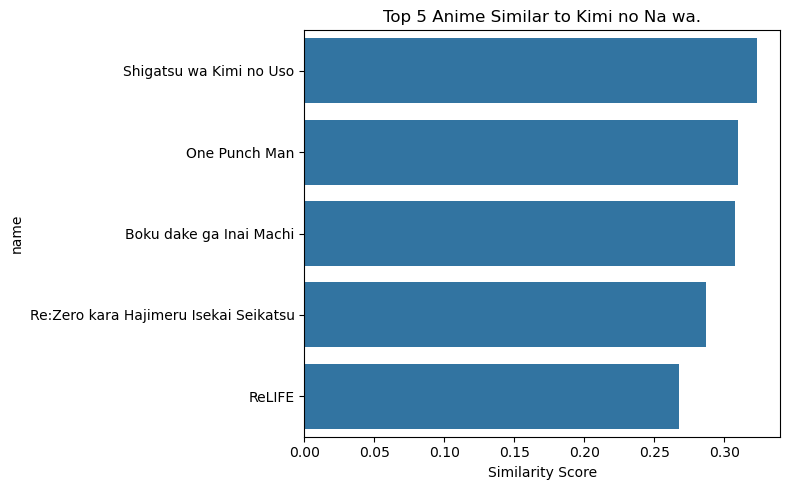

In [33]:
anime_id = top_rated_valid[top_rated_valid['name'] == 'Kimi no Na wa.']['anime_id'].values[0]
similar_scores = item_similarity_df[anime_id].drop(anime_id).sort_values(ascending=False).head(5)

similar_anime = movies_system[movies_system['anime_id'].isin(similar_scores.index)]

plt.figure(figsize=(8, 5))
sns.barplot(x=similar_scores.values, y=similar_anime['name'])
plt.title("Top 5 Anime Similar to Kimi no Na wa.")
plt.xlabel("Similarity Score")
plt.tight_layout()
plt.show()

### **Visual Insights**:
•	Bar Chart: For “Kimi no Na wa,” I showed the top 5 similar anime. “Shigatsu wa Kimi no Uso” ranked closest.

•	Heatmap: Displayed how similar the top-rated anime were to each other. Brighter colors meant stronger similarity.

•	Histogram: Showed most users rated anime between 7–10, indicating generous scoring.
